<a href="https://colab.research.google.com/github/OlgaShevel/Computer-Vision-Projects/blob/main/!AlgoritmColor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Предварительно сконструировала интересный и - полагаю нужный, например, в области медицины или геоаналитики - алгоритм сегментации изображений. Надо, конечно, еще доделывать.

Это алгоритм цветового кодирования скалярных величин (цвета, яркости пикселей изображения) значениями дивергентной шкалы coolwarm в рамках цветовой модели RGB.

В приложении к некоторым снимкам алгоритм фактически выдает аналогичные результаты алгоритму Otsu thresholding для бинарных снимков и Multi-Otsu thresholding, если тому выставить 3 класса.

Однако принцип совершенно разный. Если алгоритмы Otsu, чтобы выявить глобальный порог по сложной формуле вычисляют мин или макс дисперсию сопредельных групп пикселей, то мой алгоритм - высокоуровневый, и никаких сложных математических вычислений не проводит (хотя математически может быть описан). Он пользуется цветовой шкалой, напрямую соотнося ее значения с яркостью пикселей изображения. Собственно, это и есть "цветовое кодирование дивергентной цветовой шкалой".

Но, конечно, и цели у алгоритмов Otsu и моего - разные. Я писала свой для решения очень конкретной задачи сегментации зашумленных медицинских микроизображений (физический размер менее 1 см) с местами исчезающим разделением объекта от фона. Тогда границу нужно было бы проводить по слабому краю, но сильный градиент размывал и его так, что и адаптивный порог не справлялся. Пришлось искать способ выделять максимально близкие к глобальному порогу (=сильному краю) слабые края на фоне и на объекте.

В силу такой "природы", на других типах снимков алгоритм дает интересные эффекты, если присутствует три группы яркости пикселей (см. срезовые изображения КТ аневризмы и черепа ниже).

А еще алгоритм можно настраивать. И тогда он... что-то скроет или, наоборот, покажет то, что обычным глазом не всегда видно (см. фото чека и часов).

(Еще для сравнения приложила алгоритмы сегментации, прежде всего, бинарной - Niblack, Сауvola, Triangle. Но их результаты, честно говоря, аховые, по крайней мере, на этих примерах, хотя иногда Triangle неплох).







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy
import os
import sys
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import matplotlib.cm as cm
from PIL import Image, ImageFilter
from matplotlib.image import imread
%matplotlib inline

from skimage import io
from skimage.filters import threshold_multiotsu, threshold_niblack, threshold_sauvola, threshold_triangle
from skimage.util import img_as_ubyte

In [ ]:
# Глобальные переменные
min_diff_brightness = None
original_center = None
blue_gray_balance = None
red_gray_balance = None
blue_border = None
red_border = None
gray_image = None


def process_image(file_path):
    global min_diff_brightness, original_center, blue_gray_balance, blue_border, red_gray_balance, red_border, gray_image

    image = cv2.imread(file_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = gray_image.shape
    pixel_brightness = gray_image.flatten()

    # Создать цветовую карту "coolwarm" ----------------------------------------
    cmap = plt.get_cmap('coolwarm')

    normalized_brightness = (pixel_brightness -
                             np.min(pixel_brightness)) / (np.max(pixel_brightness) -
                                                          np.min(pixel_brightness))
    point_colors_rgba = cmap(normalized_brightness)

    # Просчитать новый центр вместо 127
    point_colors_rgb = point_colors_rgba[:, :3]
    red_sum = point_colors_rgb[:, 0]
    blue_sum = point_colors_rgb[:, 2]
    red_percentage = (red_sum / (red_sum + blue_sum)) * 100     # Процентное соотношение красного и синего
    blue_percentage = (blue_sum / (red_sum + blue_sum)) * 100
    red_blue_diff = np.abs(red_percentage - blue_percentage)    # Разница между красным и синим
    min_diff_index = np.argmin(red_blue_diff)                   # Индекс пикселя с мин разницей между красным и синим
    min_diff_brightness = pixel_brightness[min_diff_index]

    # Параметры для гистограммы coolwarm -------------------------------------------
    original_center = 127                                       # Центр в стандартной шкале coolwarm
    min_diff_brightness = min_diff_brightness                   # Смещенный центр для изображения

    if min_diff_brightness <= 41:                               # Предотвращение ухода значений слабых краев
        min_diff_brightness = 41                                # ниже 0 и выше 255
    if min_diff_brightness >= 223:
        min_diff_brightness = 223

    blue_gray_balance = 87                                      # Граница синего и серого в шкале с центром 127
    red_gray_balance = 159                                      # Граница красного и серого в шкале с центром 127

    shift = original_center - min_diff_brightness               # Смещение и коэффициенты компенсации
    total_brightness = 255
    proportion = (total_brightness - 1) / 255
    adjusted_shift = shift * proportion

    blue_border = blue_gray_balance - adjusted_shift            # Новый баланс с учетом компенсации
    red_border = red_gray_balance - adjusted_shift


    return gray_image

In [ ]:
100-146 = как у Мульти Отцу

In [ ]:
# ПРОСЧЕТ ПАРАМЕТРОВ ДЛЯ ШКАЛЫ COOLWARM ========================================
# и сравнение с пороговыми алгоритмами

def alg_other(gray_image):
    global min_diff_brightness, original_center, blue_border, red_border

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))

    # Параметры для гистограммы coolwarm -------------------------------------------
    original_center = 127
    min_diff_brightness = min_diff_brightness

    if min_diff_brightness <= 41:
        min_diff_brightness = 41
    if min_diff_brightness >= 223:
        min_diff_brightness = 223

    original_blue_border = 87
    original_red_border = 159

    shift = original_center - min_diff_brightness
    total_brightness = 255
    proportion = (total_brightness - 1) / 255
    adjusted_shift = shift * proportion

    blue_border = original_blue_border - adjusted_shift
    red_border = original_red_border - adjusted_shift

    # Гистограмма coolwarm -----------------------------------------------------
    histr = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    histr_norm = histr / np.max(histr)
    cmap = cm.coolwarm
    colors = cmap(np.linspace(0, 1, 256))

    # Исправлено: используем ax[0, 0] для первой оси
    for i in range(256):
        ax[0, 0].axvline(x=i, color=colors[i][:3], linewidth=2, alpha=0.6)
    ax[0, 0].plot(histr_norm, color='k')
    ax[0, 0].fill_between(np.arange(256), histr_norm.flatten(), color='gray', alpha=0.5)
    ax[0, 0].set_xlim([0, 255])
    ax[0, 0].set_title('Гистограмма по дивергентной цветовой шкале', size=10)

    # Линии баланса гистограммы coolwarm ---------------------------------------
    #ax[0, 0].axvline(x=original_center, color='k', linestyle='-',
    #                 label=f'Центр шкалы coolwarm в RGB - {original_center:.0f}')
    ax[0, 0].axvline(x=min_diff_brightness, color='lime', linestyle='--',
                     label=f'Смещенный центр - {min_diff_brightness:.0f}')
    ax[0, 0].axvline(x=blue_border, color='blue', linestyle='--',
                     label=f'Баланс синий и серый - {blue_border:.0f}')
    ax[0, 0].axvline(x=red_border, color='red', linestyle='--',
                     label=f'Баланс красный и серый - {red_border:.0f}')
    ax[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, 0.0),
                    fontsize=8, markerscale=1, ncol=1)

    # Гистограмма изображения Multi-Otsu ---------------------------------------
    thresholds = threshold_multiotsu(gray_image, classes=4)
    regions = np.digitize(gray_image, bins=thresholds)
    inverted_regions = np.max(regions) - regions

    ax[0, 1].hist(gray_image.ravel(), bins=256)
    ax[0, 1].set_title('Гистограмма Multi-Otsu', size=10)
    for thresh in thresholds:
        ax[0, 1].axvline(thresh, color='r',
                         label=f'Порог - {thresh:.0f}')
        ax[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, 0.0),
                        fontsize=10, markerscale=1, ncol=1)

    # Сегментированное изображение после Multi-Otsu ----------------------------
    ax[0, 2].imshow(inverted_regions, cmap='jet')
    ax[0, 2].set_title('Сегментация Multi-Otsu', size=10)

    # Сегментированное изображение Методом Niblack -----------------------------
    thresh_niblack = threshold_niblack(gray_image, window_size=25, k=0.8)
    binary_niblack = gray_image > thresh_niblack
    binary_niblack = img_as_ubyte(binary_niblack)
    inverted_binary_niblack = np.max(binary_niblack) - binary_niblack
    ax[1, 0].imshow(inverted_binary_niblack, cmap='gray')
    ax[1, 0].set_title('Сегментация Niblack', size=10)

    # Сегментированное изображение Методом Сауvola -----------------------------
    thresh_sauvola = threshold_sauvola(gray_image, window_size=25)
    binary_sauvola = gray_image > thresh_sauvola
    binary_sauvola = img_as_ubyte(binary_sauvola)
    inverted_binary_sauvola = np.max(binary_sauvola) - binary_sauvola
    ax[1, 1].imshow(inverted_binary_sauvola, cmap='gray')
    ax[1, 1].set_title('Сегментация Сауvola', size=10)

    # Сегментированное изображение Методом Triangle ----------------------------
    thresh_triangle = threshold_triangle(gray_image)
    binary_triangle = gray_image > thresh_triangle
    binary_triangle = img_as_ubyte(binary_triangle)
    inverted_binary_triangle = np.max(binary_triangle) - binary_triangle
    ax[1, 2].imshow(inverted_binary_triangle, cmap='gray')
    ax[1, 2].set_title('Сегментация Triangle', size=10)

    plt.tight_layout()
    plt.show()

In [ ]:
def contour_cw(gray_image):
    global min_diff_brightness, original_center, blue_border, red_border

    # Копия изображения --------------------------------------------------------
    original_image = Image.open(file_path)
    copied_image = original_image.copy()

    # Маска для сильного края --------------------------------------------------
    height, width = gray_image.shape
    mask = np.zeros_like(gray_image)
    mask[gray_image <= min_diff_brightness] = 255
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    strong_contour = np.ones((height, width, 3), dtype=np.uint8) * 255
    cv2.drawContours(strong_contour, contours, -1, (0, 128, 0), 1)

    # Маска для слабого синего края --------------------------------------------
    mask2 = np.zeros_like(gray_image)
    mask2[gray_image <= blue_border] = 255
    contours, _ = cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    weak_blue_contour = np.ones((height, width, 3), dtype=np.uint8) * 255
    cv2.drawContours(weak_blue_contour, contours, -1, (0, 0, 255), 1)

    # Маски для слабого красного края ------------------------------------------
    mask3 = np.zeros_like(gray_image)
    mask3[gray_image <= red_border] = 255
    contours, _ = cv2.findContours(mask3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    weak_red_contour = np.ones((height, width, 3), dtype=np.uint8) * 255
    cv2.drawContours(weak_red_contour, contours, -1, (255, 0, 0), 1)


    # Вывести контуры на изображении -------------------------------------------
    fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
    gray_image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    ax.imshow(copied_image)
    ax.set_title('Изображение в натуральный размер', size=10)
    #ax.contour(mask, levels=[0.5, 1], colors='green', linewidths=0.2)
    #ax.contour(mask2, levels=[0.5, 1], colors='blue', linewidths=0.2)
    #ax.contour(mask3, levels=[0.5, 1], colors='red', linewidths=0.2)
    #fig, ax = plt.subplots(figsize=(20, 20))
    #ax.imshow(gray_image, cmap='gray', interpolation='nearest')
    #ax.set_title('Изображение с увеличением', size=10)
    #ax.contour(mask, levels=[0.5, 1], colors='green', linewidths=0.5)
    #ax.contour(mask2, levels=[0.5, 1], colors='blue', linewidths=0.5)
    #ax.contour(mask3, levels=[0.5, 1], colors='red', linewidths=0.5)

    # Создать фигуру с подграфиками --------------------------------------------
    fig, axs = plt.subplots(2, 3, figsize=(16, 8))
    axs[0, 0].imshow(strong_contour)
    axs[0, 0].set_title('Контур сильного края', size=10)
    axs[0, 1].imshow(weak_blue_contour)
    axs[0, 1].set_title('Контур слабого края (по яркости 127 --> 0)', size=10)
    axs[0, 2].imshow(weak_red_contour)
    axs[0, 2].set_title('Контур слабого края (по яркости 127 --> 255)', size=10)
    axs[1, 0].imshow(mask, cmap='gray')
    axs[1, 0].set_title('Маска сильного края', size=10)
    axs[1, 1].imshow(mask2, cmap='gray')
    axs[1, 1].set_title('Маска слабого края (по яркости 127 --> 0)', size=10)
    axs[1, 2].imshow(mask3, cmap='gray')
    axs[1, 2].set_title('Маска слабого края (по яркости 127 --> 255)', size=10)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/KLETKA/BloodImage_00028.jpg'
original_image = Image.open(file_path)
copied_image = original_image.copy()


<IPython.core.display.Javascript object>

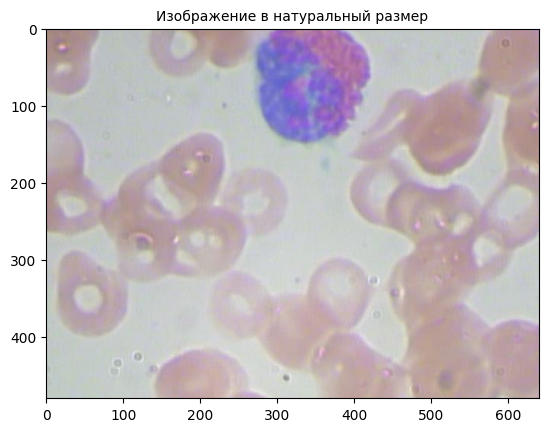

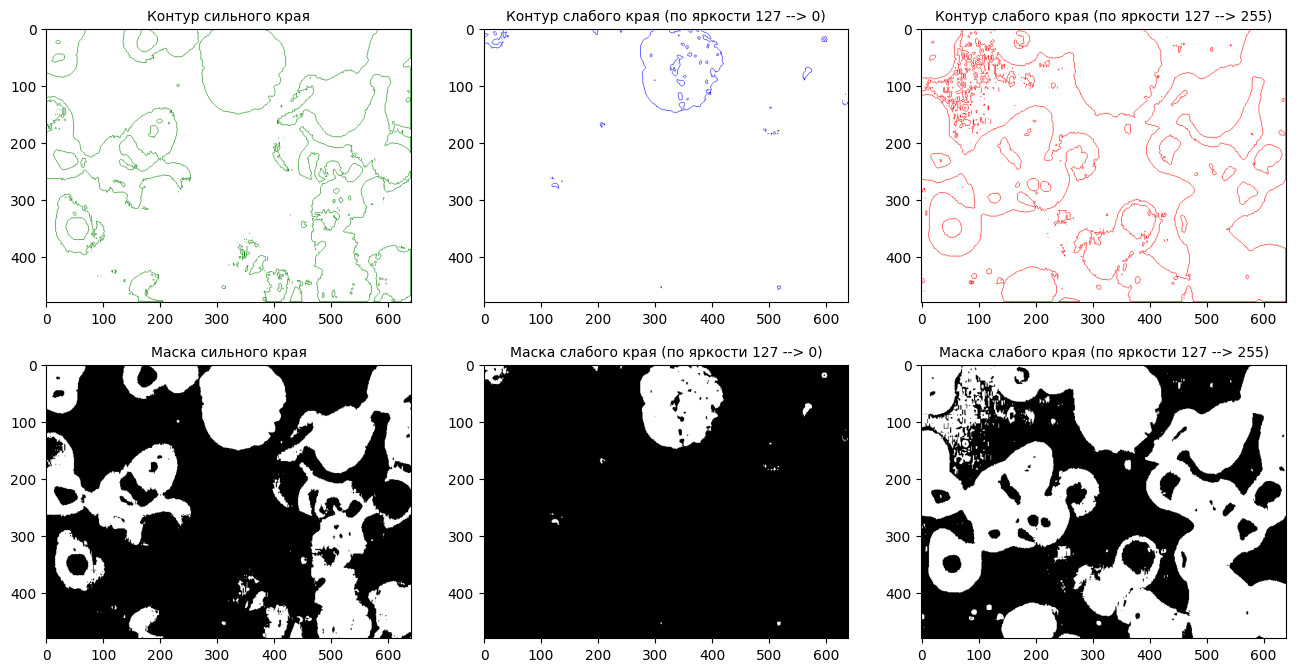

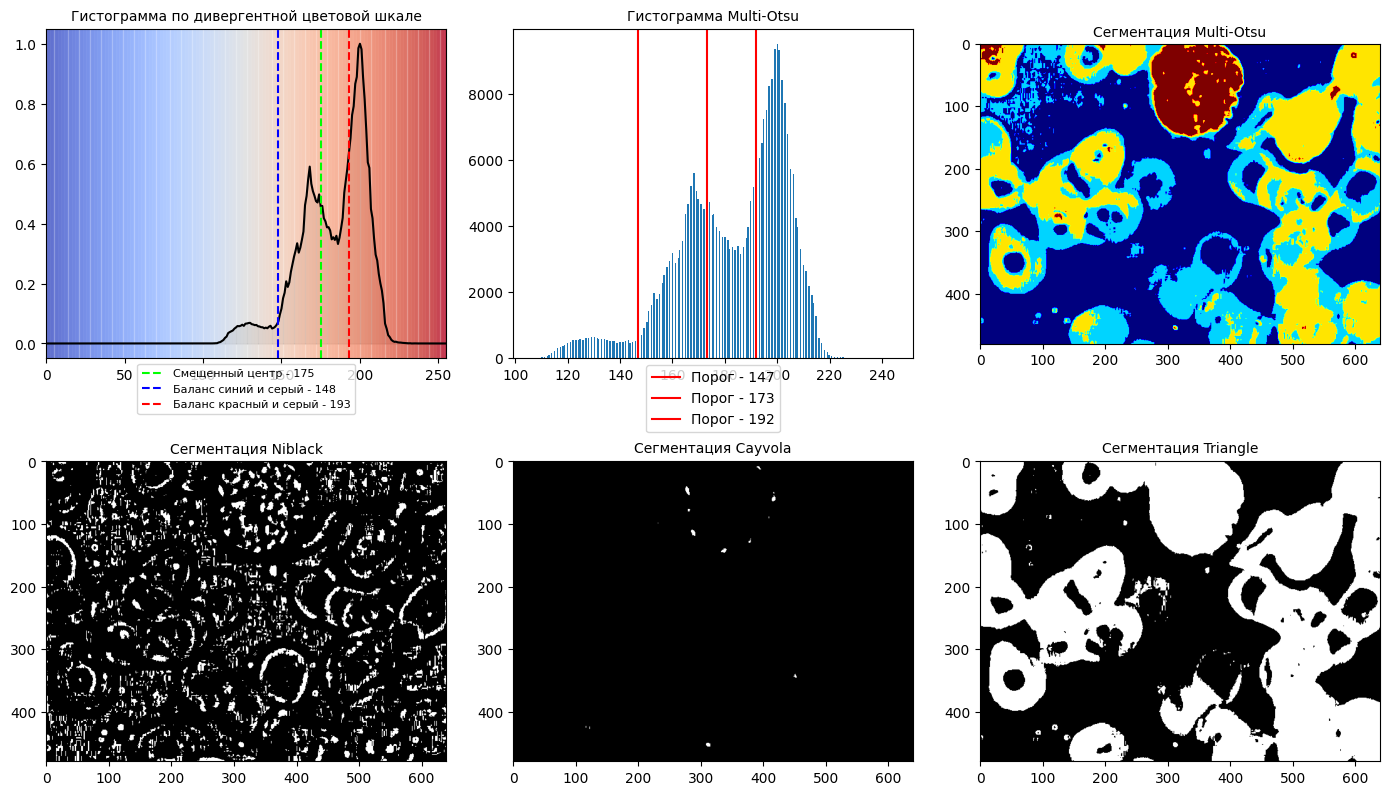

In [ ]:
from google.colab import output
output.no_vertical_scroll()

file_path = '/content/drive/MyDrive/KLETKA/BloodImage_00028.jpg'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

<IPython.core.display.Javascript object>

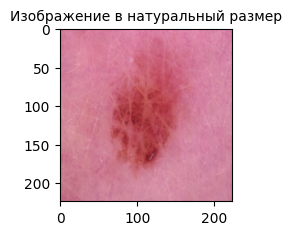

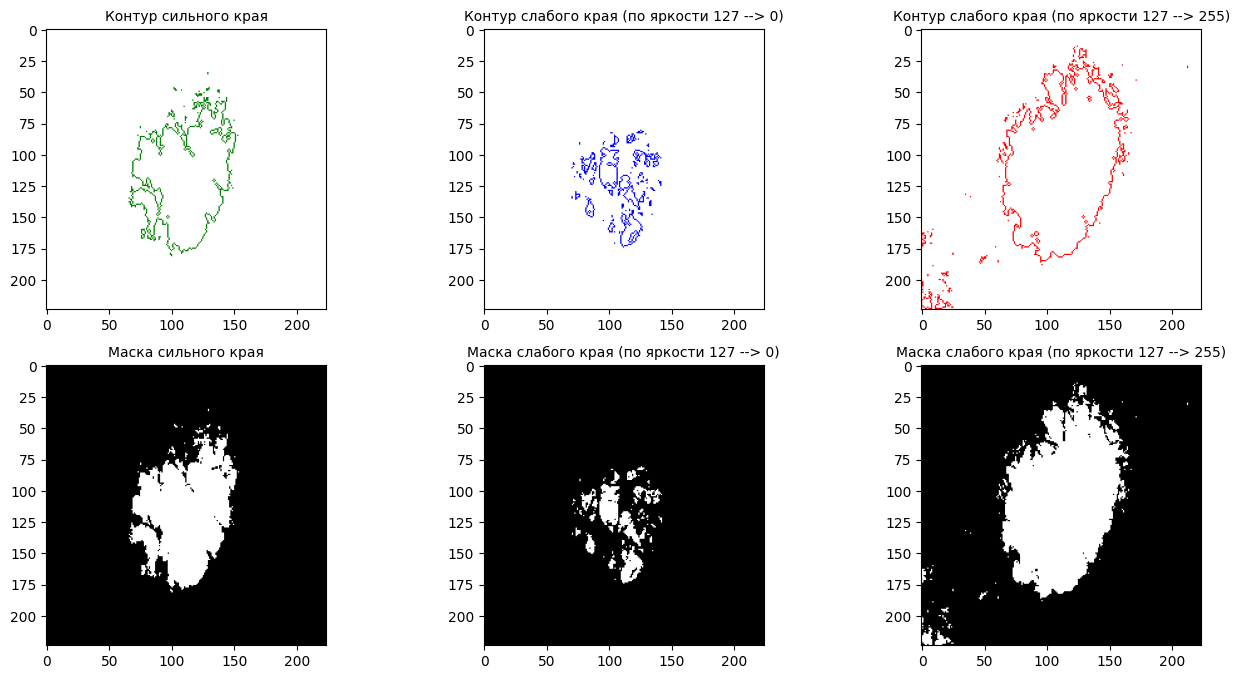

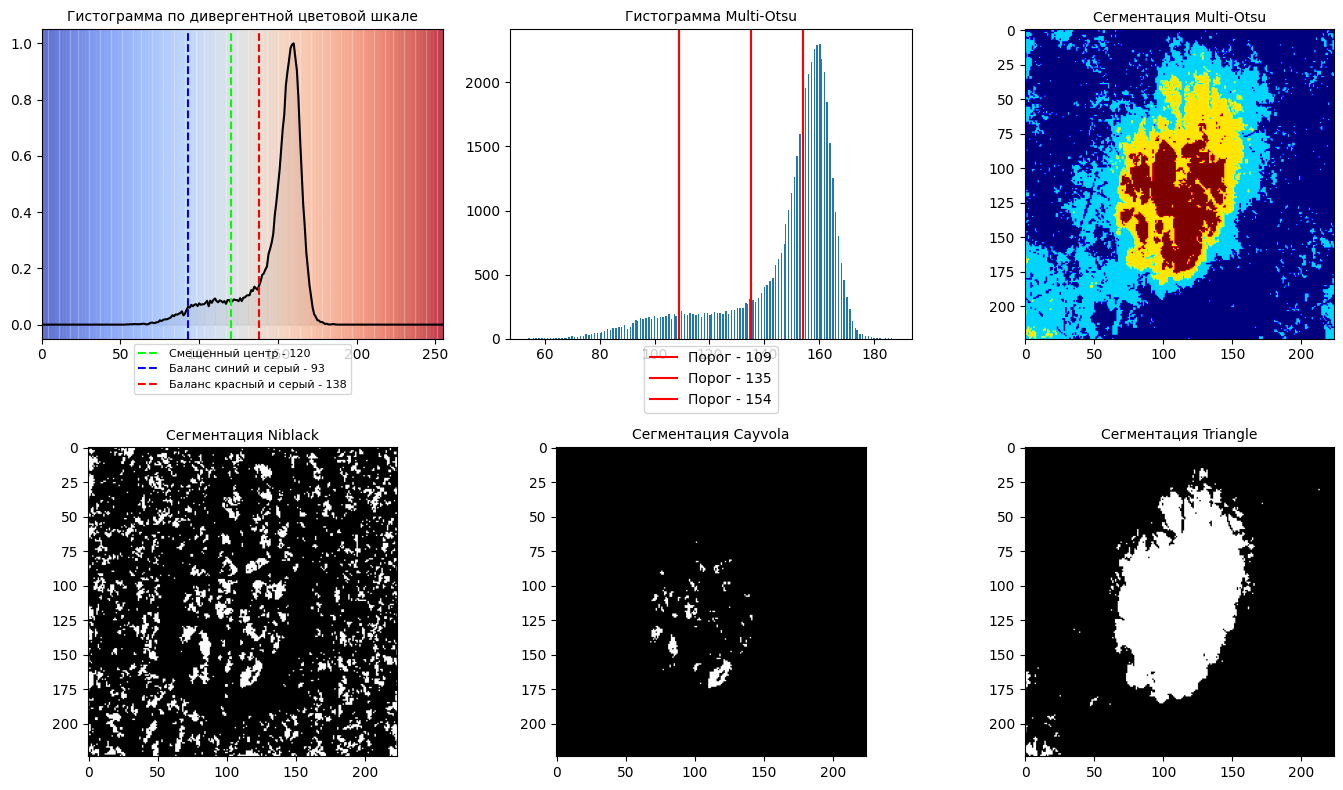

In [ ]:
from google.colab import output
output.no_vertical_scroll()

file_path = '/content/drive/MyDrive/KLETKA/26.jpg'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

КТ с признаками аневризмы аорты тип III

https://mosmed.ai/datasets/mosmeddata-kt-s-priznakami-anevrizmyi-aortyi-tip-iii/

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/ANEVRISM/neskolko_png/image_5.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

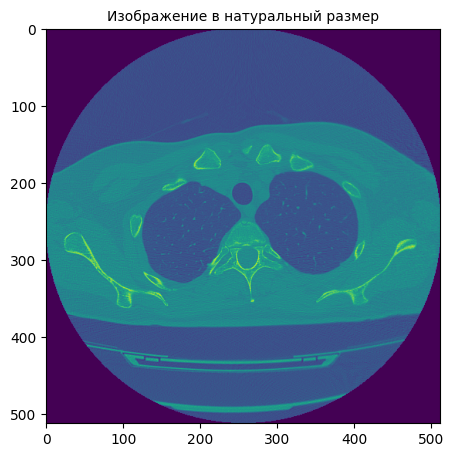

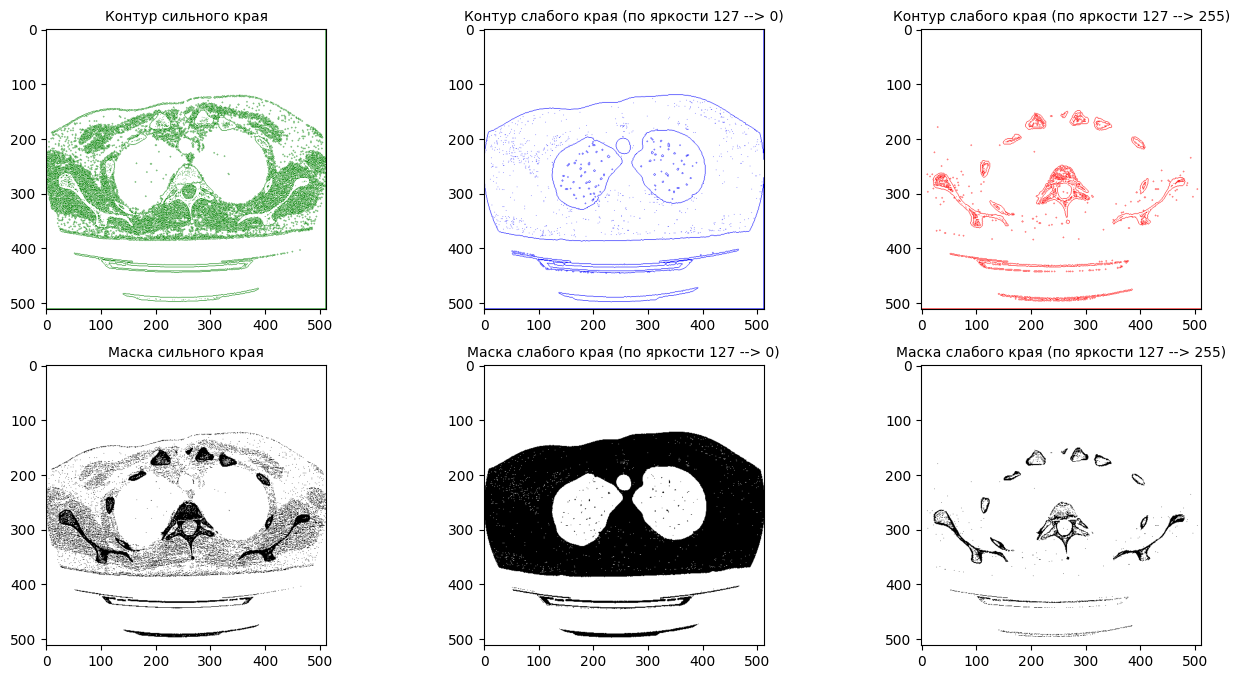

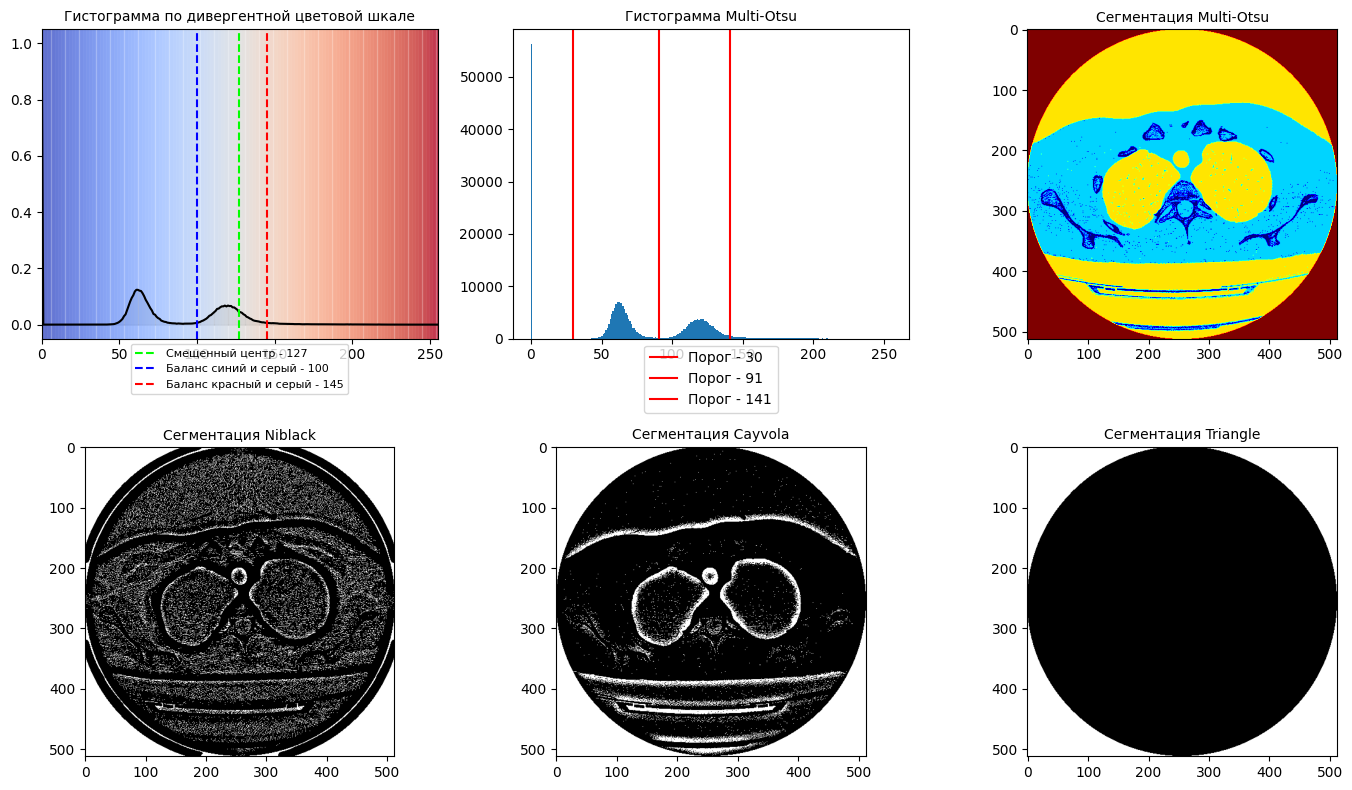

In [ ]:
from google.colab import output
output.no_vertical_scroll()

file_path = '/content/drive/MyDrive/ANEVRISM/neskolko_png/image_5.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

Нервные клетки человека (большие темные) и глиальные клетки (маленькие черные)

https://homepages.inf.ed.ac.uk/rbf/HIPR2/libmed.htm

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/KLETKA/cel4.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

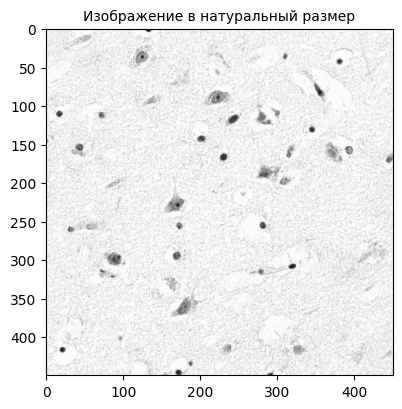

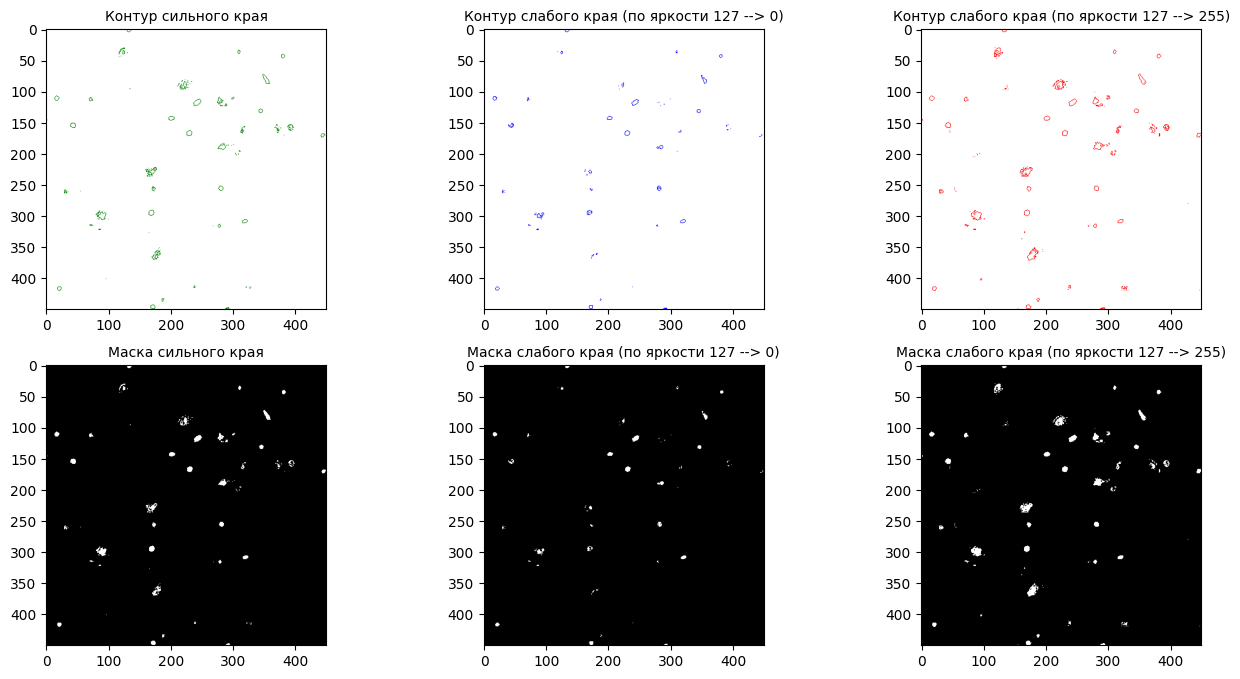

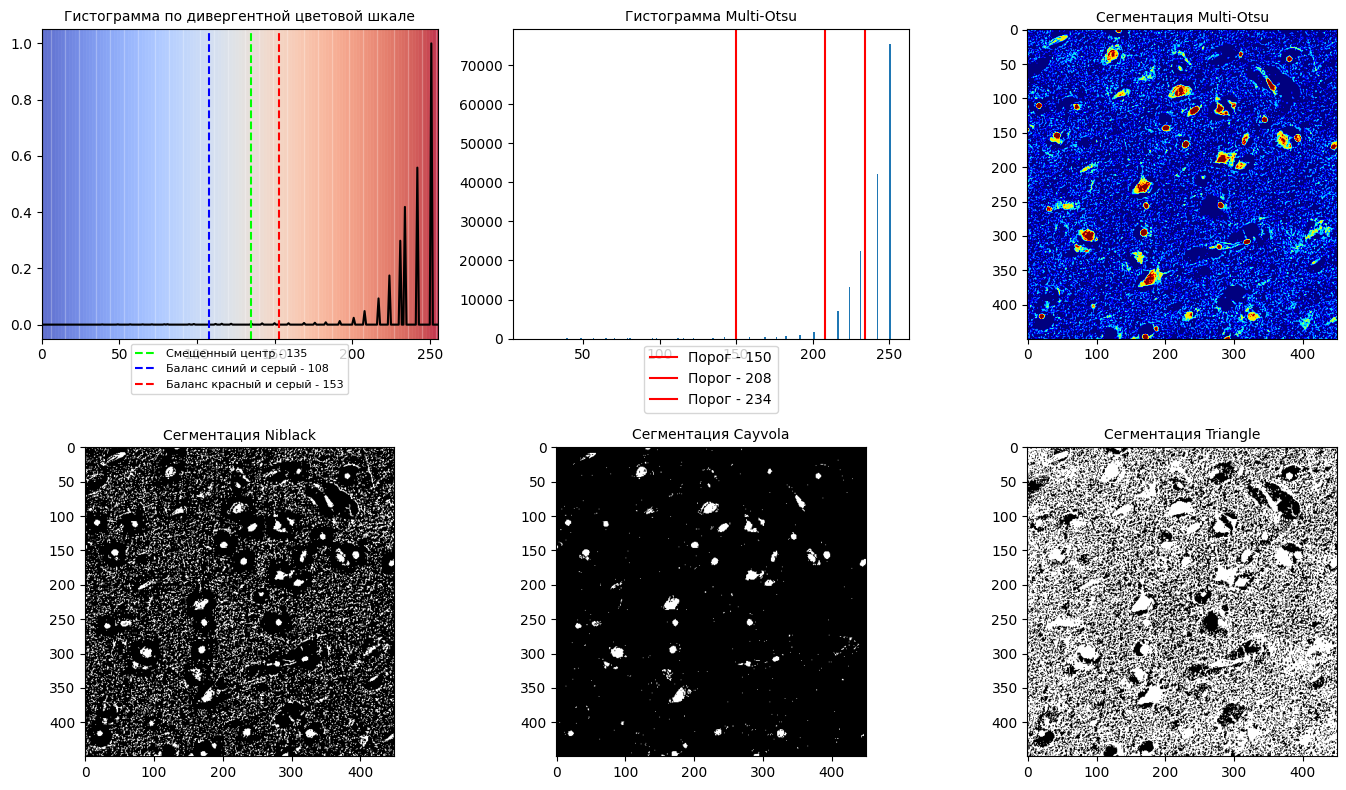

In [ ]:
from google.colab import output
output.no_vertical_scroll()

file_path = '/content/drive/MyDrive/KLETKA/cel4.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/KLETKA/Copy of image_399.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

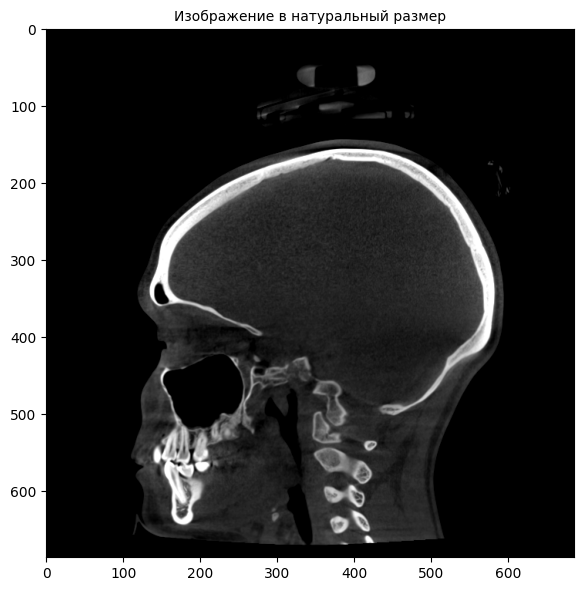

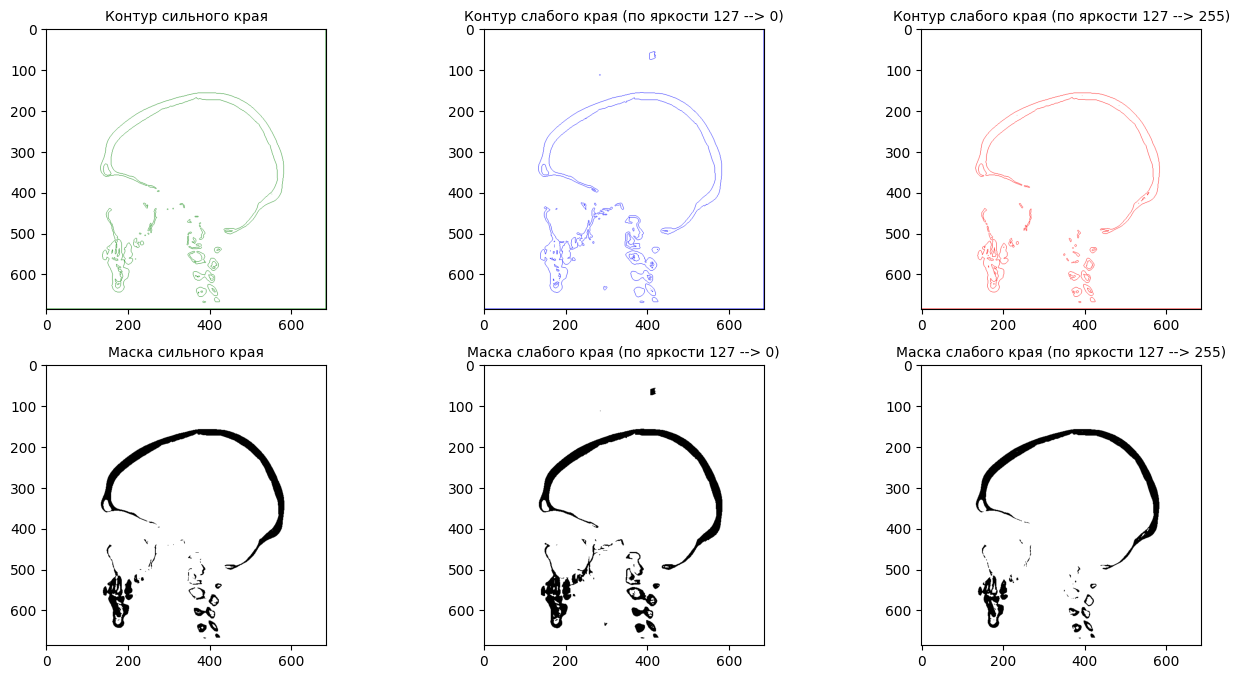

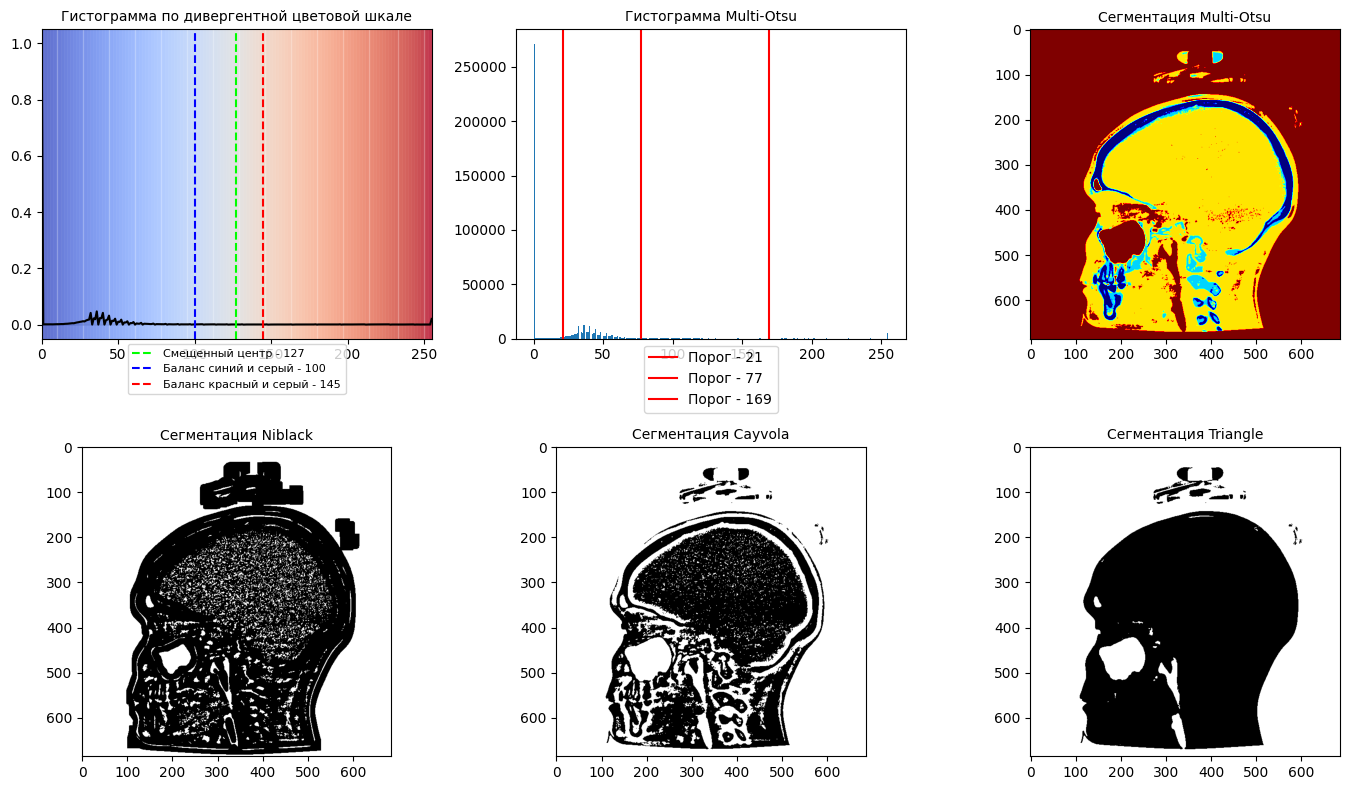

In [ ]:
from google.colab import output
output.no_vertical_scroll()

file_path = '/content/drive/MyDrive/KLETKA/Copy of image_399.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/0.4/!!PROJECT_DICOM_504649/FRAGM/Cropp_Left_64х64/cropped_227.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

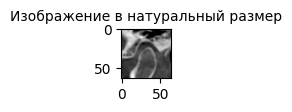

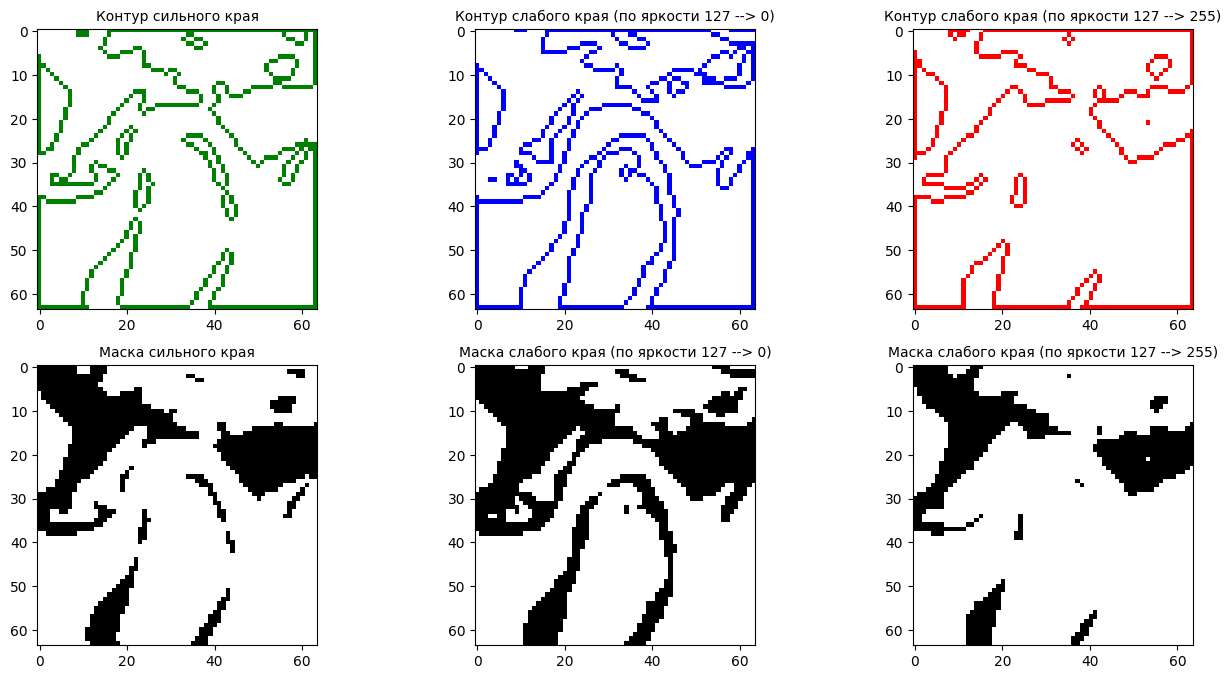

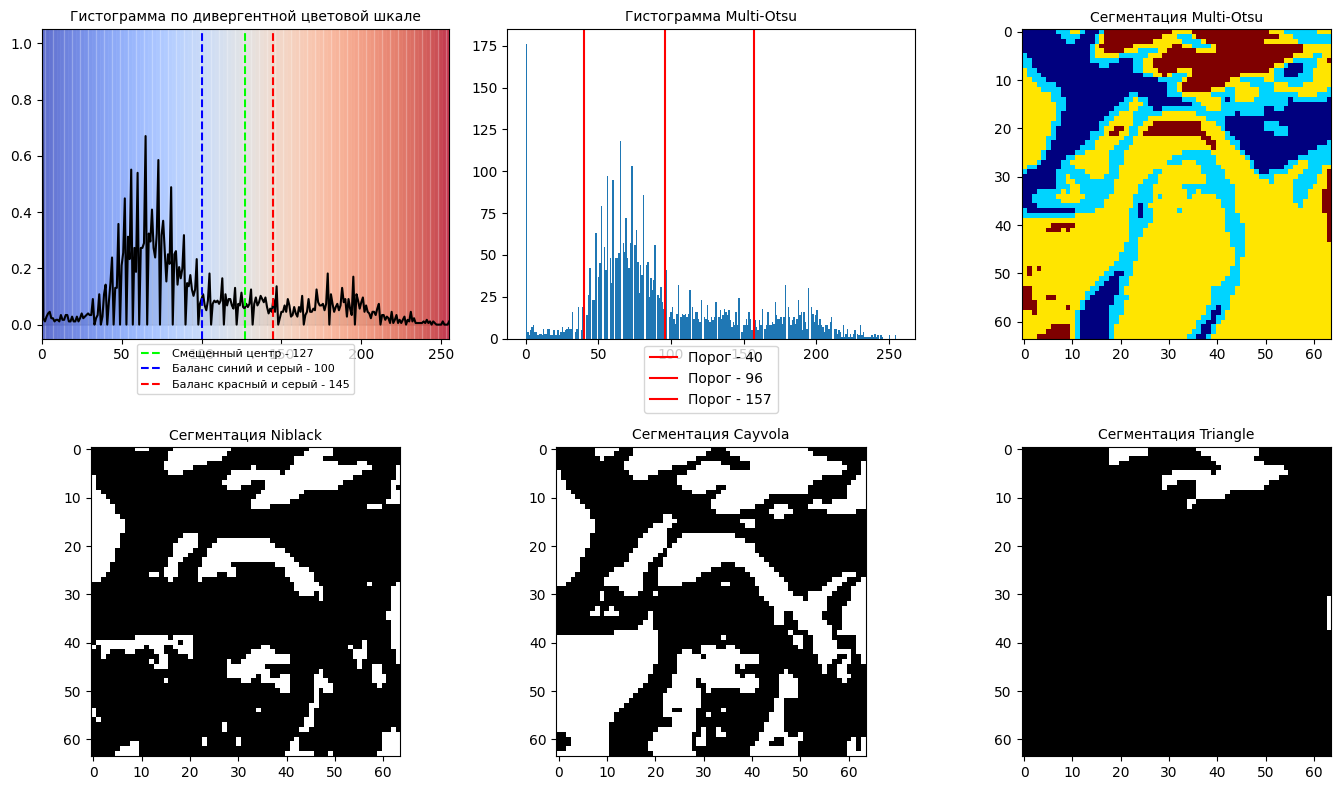

In [ ]:
from google.colab import output
output.no_vertical_scroll()


file_path = '/content/drive/MyDrive/0.4/!!PROJECT_DICOM_504649/FRAGM/Cropp_Left_64х64/cropped_227.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/AERO/image_3.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

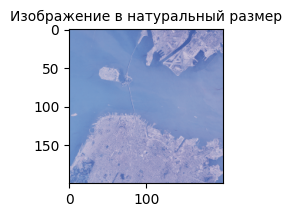

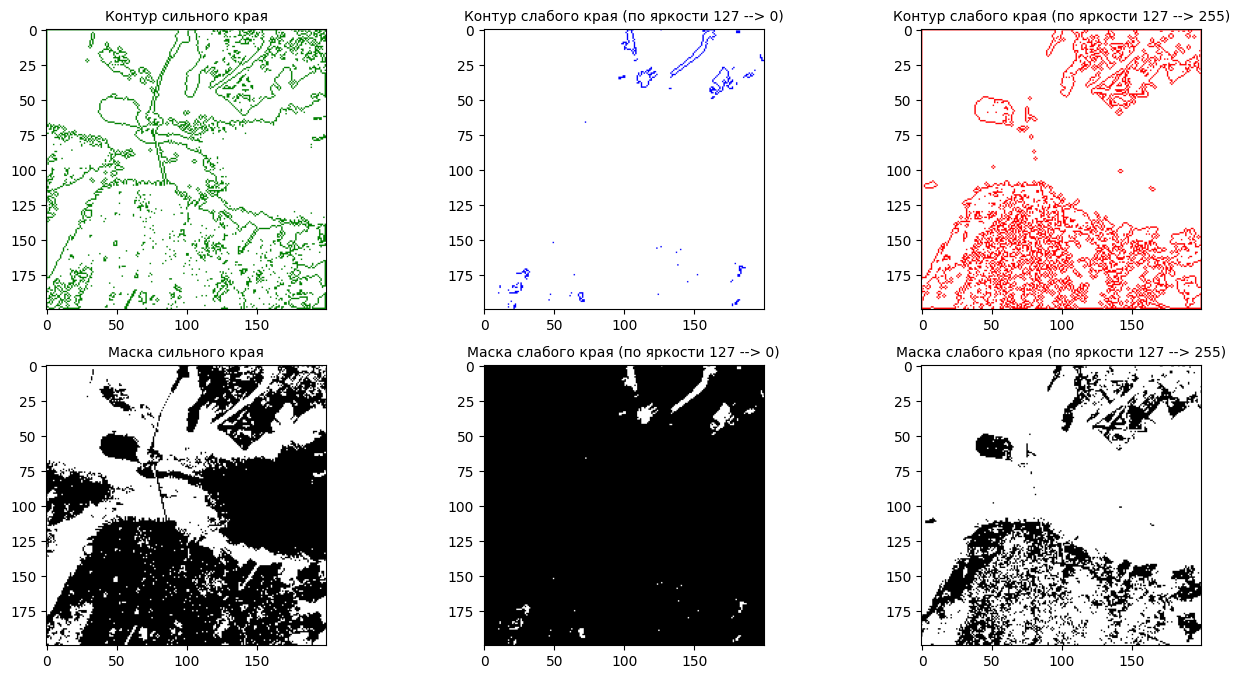

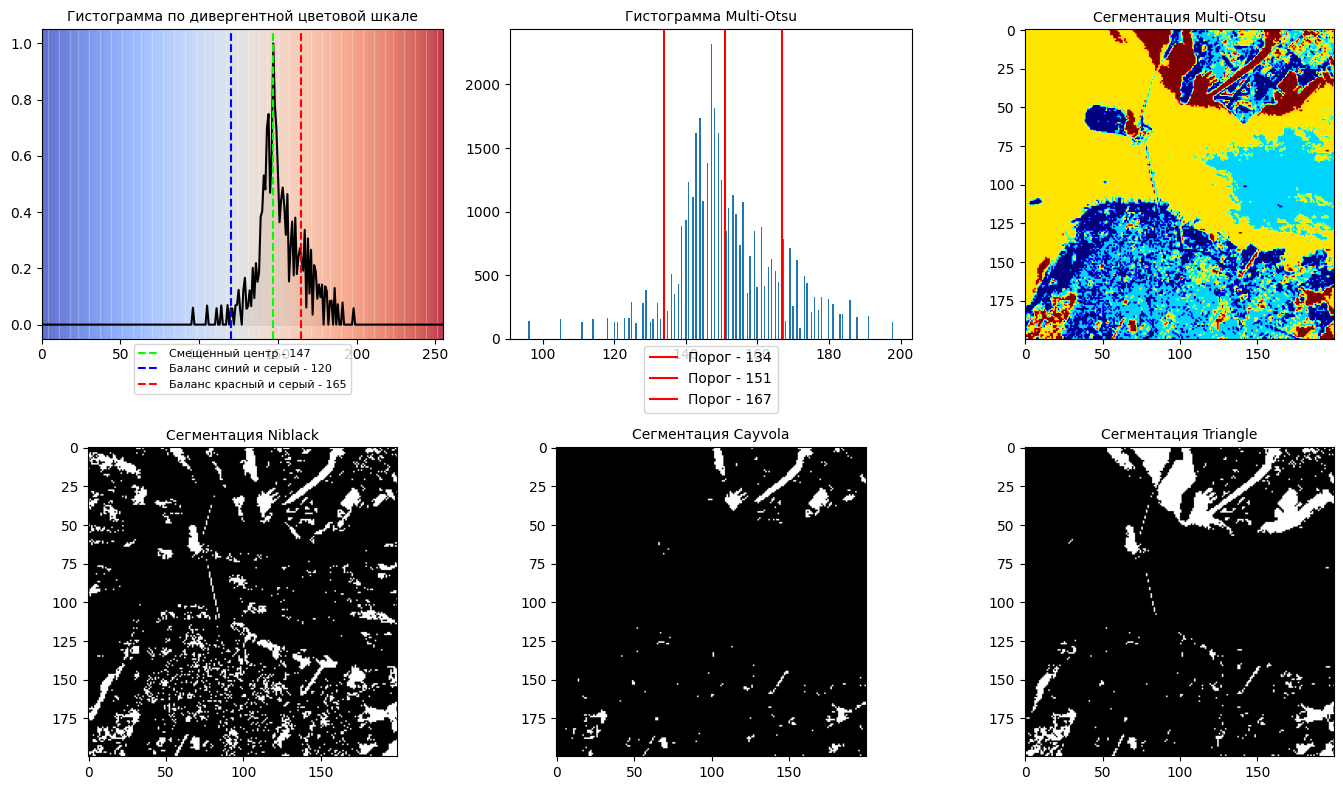

In [ ]:
from google.colab import output
output.no_vertical_scroll()


file_path = '/content/drive/MyDrive/AERO/image_3.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/AERO/image_0.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

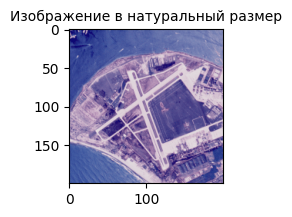

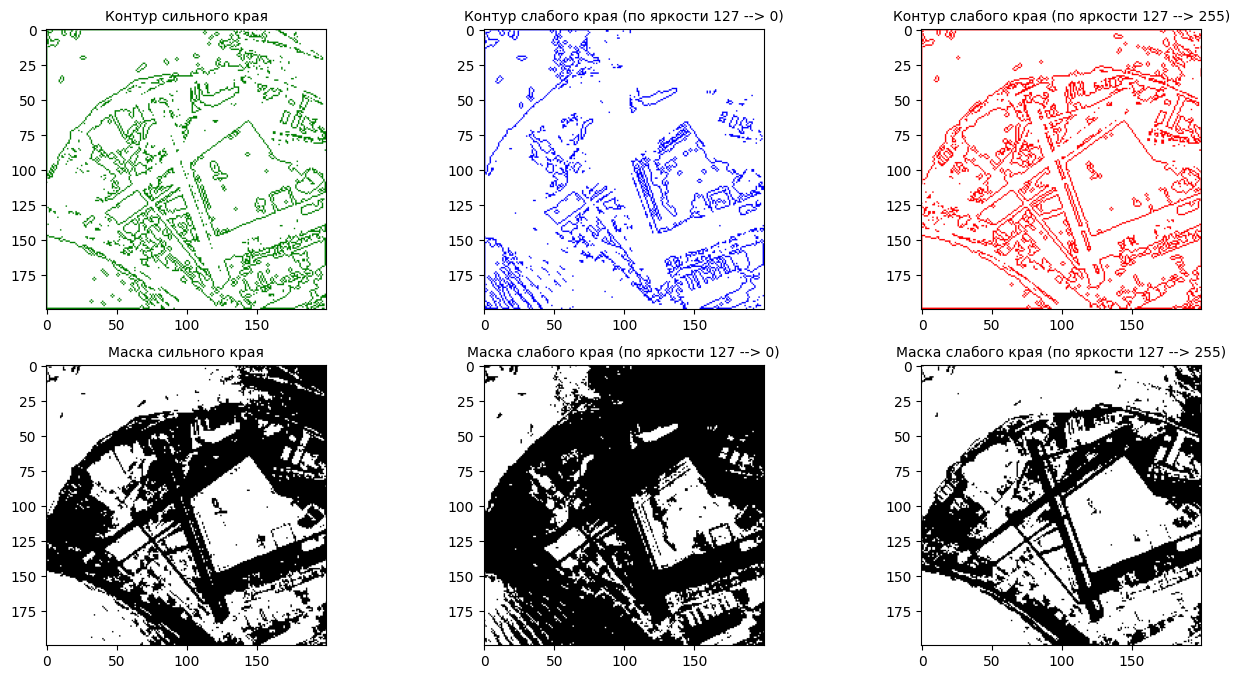

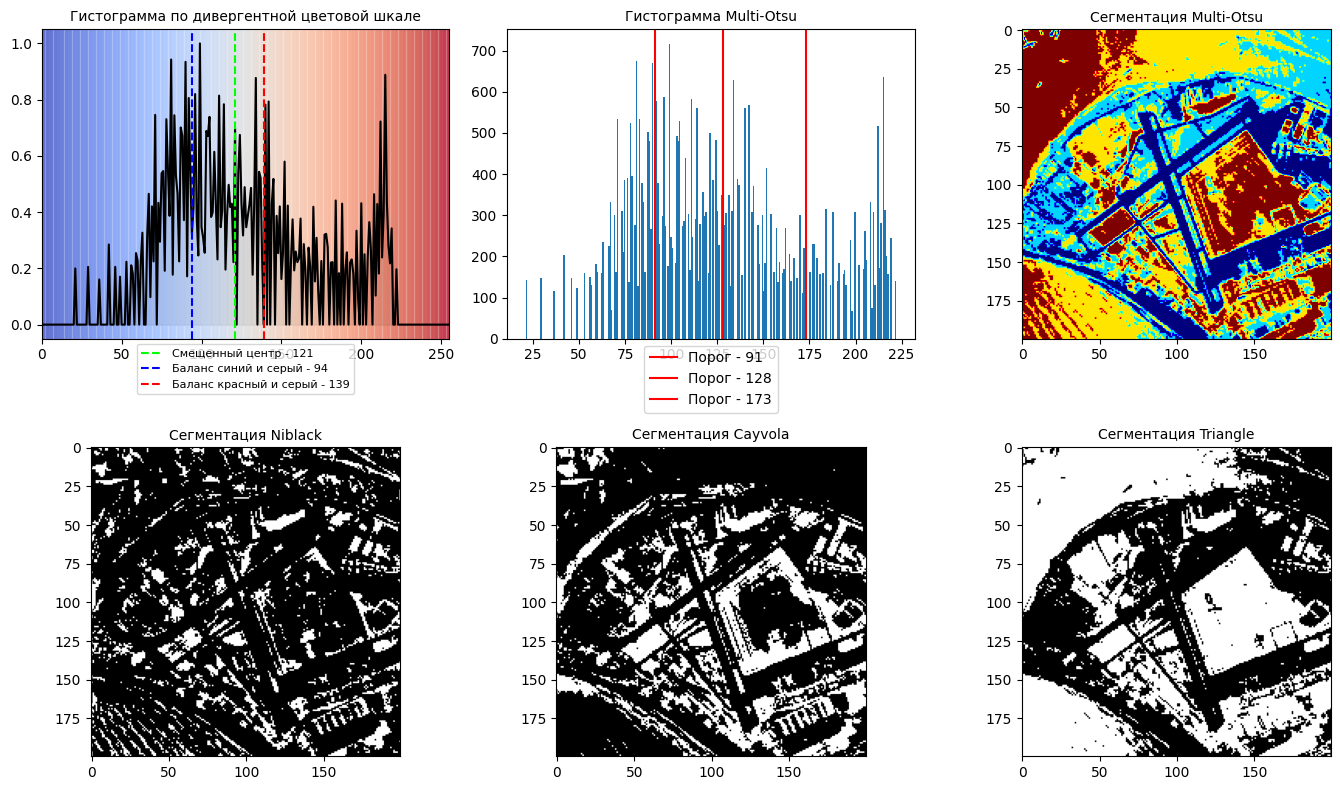

In [ ]:
from google.colab import output
output.no_vertical_scroll()


file_path = '/content/drive/MyDrive/AERO/image_5.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/AERO/image_7.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

<IPython.core.display.Javascript object>

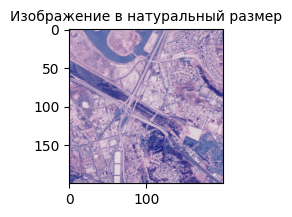

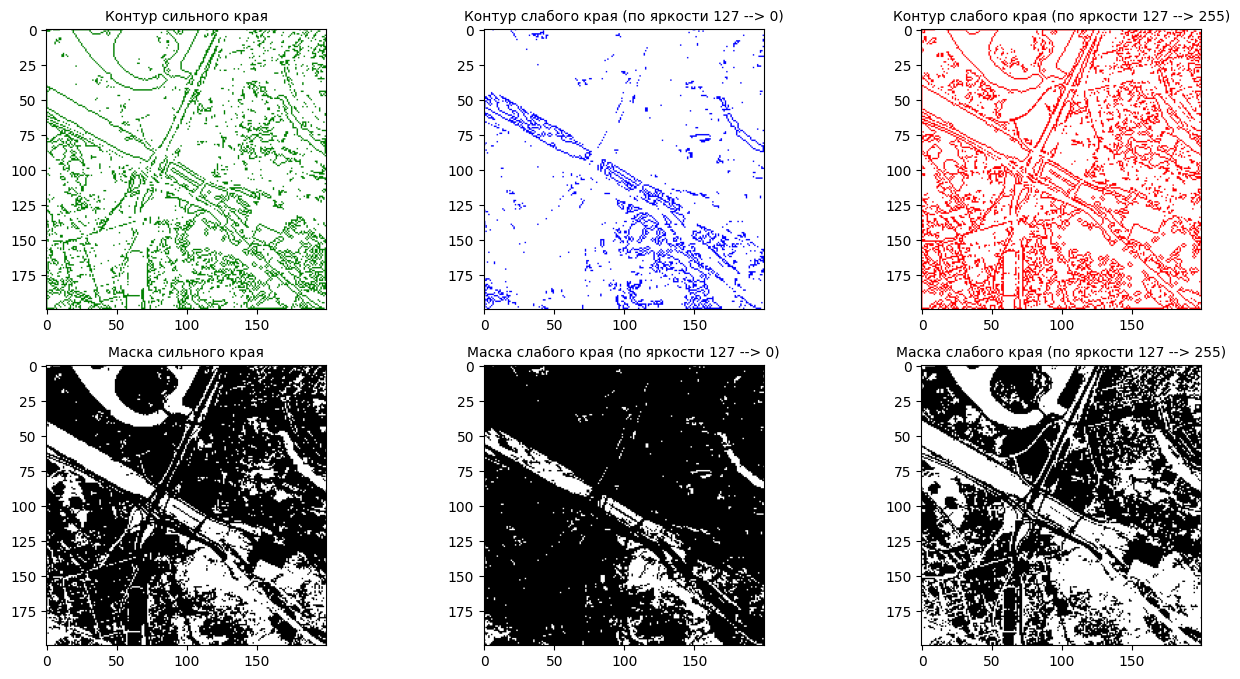

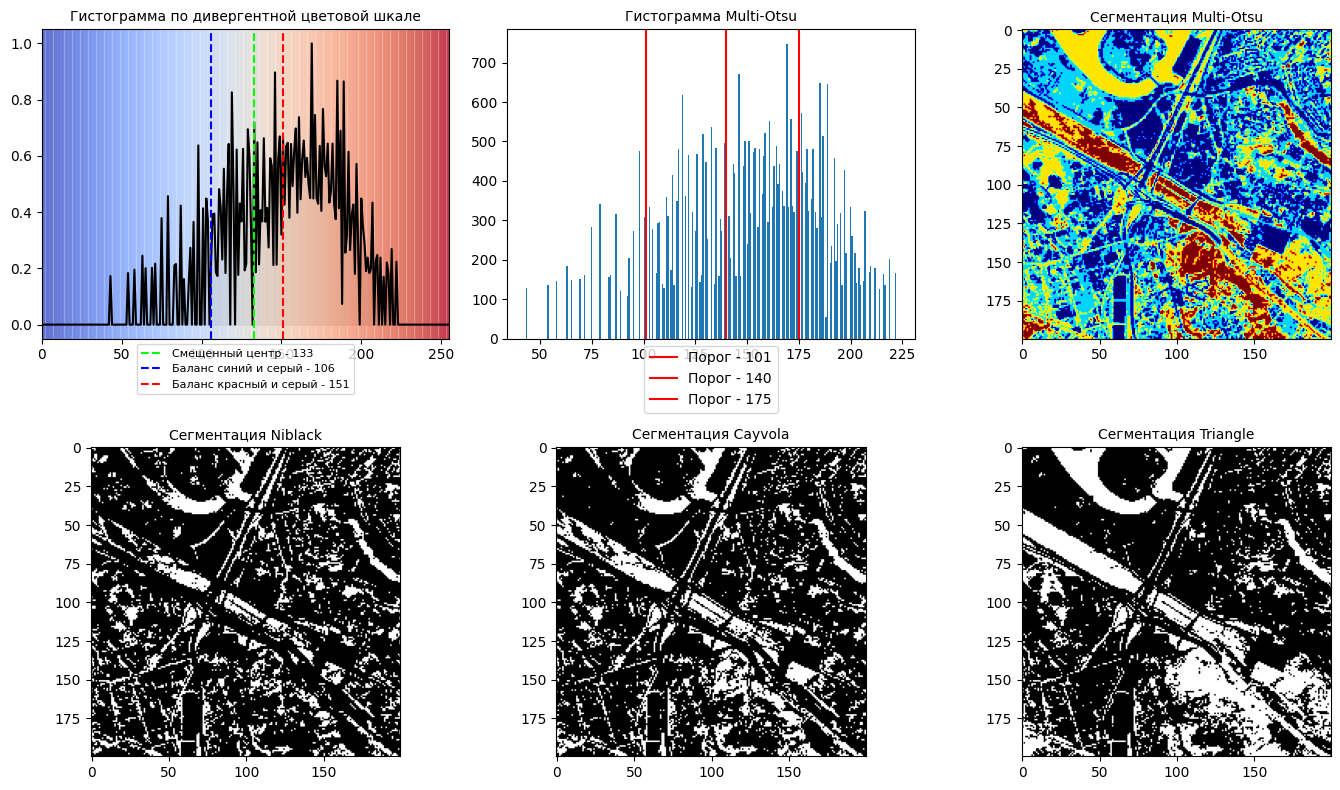

In [ ]:
from google.colab import output
output.no_vertical_scroll()


file_path = '/content/drive/MyDrive/AERO/image_7.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

<IPython.core.display.Javascript object>

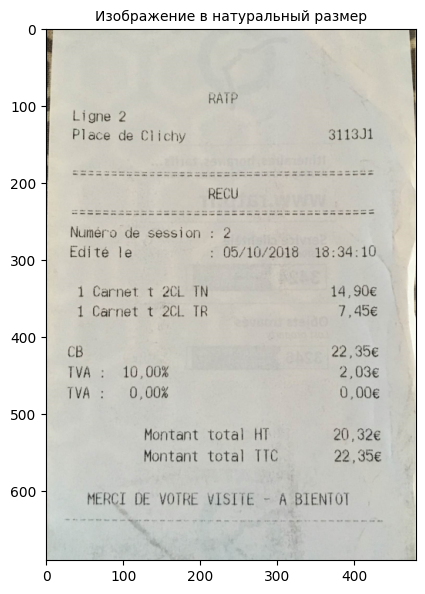

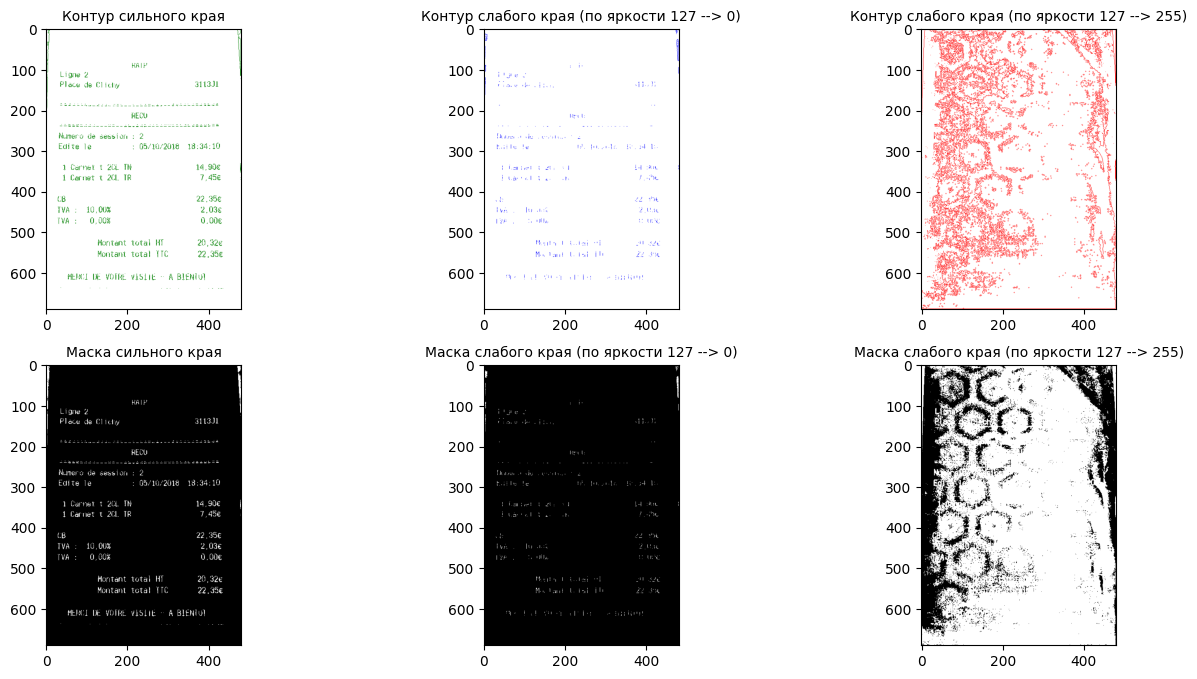

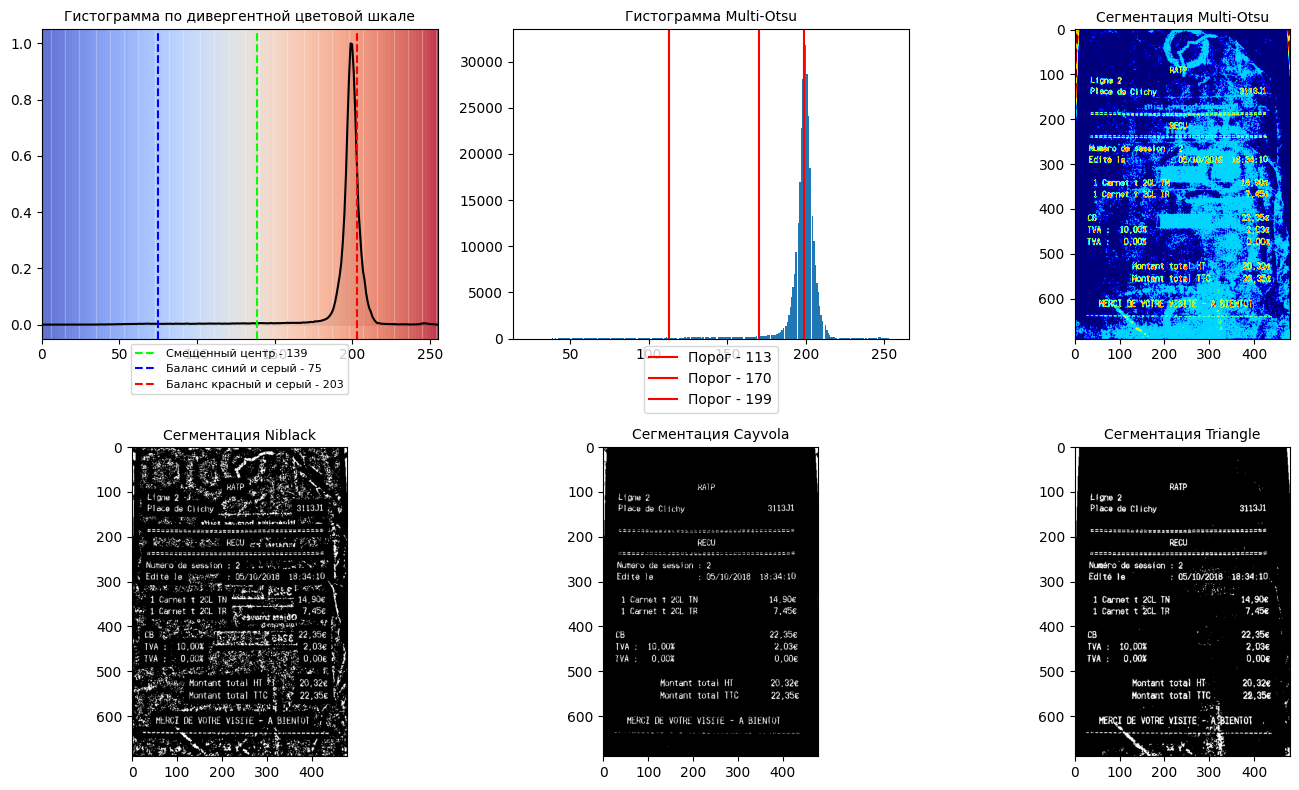

In [ ]:
from google.colab import output
output.no_vertical_scroll()


file_path = '/content/drive/MyDrive/CHEKS/FILES/image_0.png'
gray_image = process_image(file_path)
contour_cw(gray_image)
alg_other(gray_image)

In [ ]:
from PIL import Image

# Путь к исходному изображению
file_path = '/content/drive/MyDrive/ZNAK/wat1.png'
original_image = Image.open(file_path)
copied_image = original_image.copy()

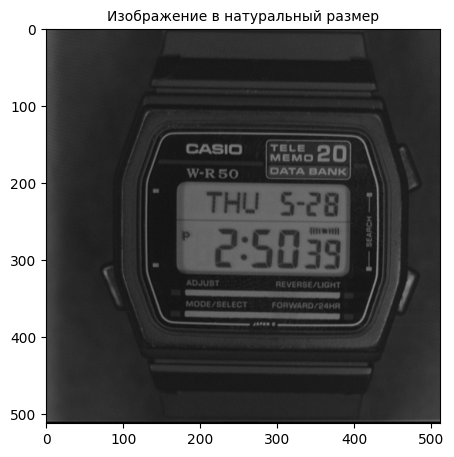

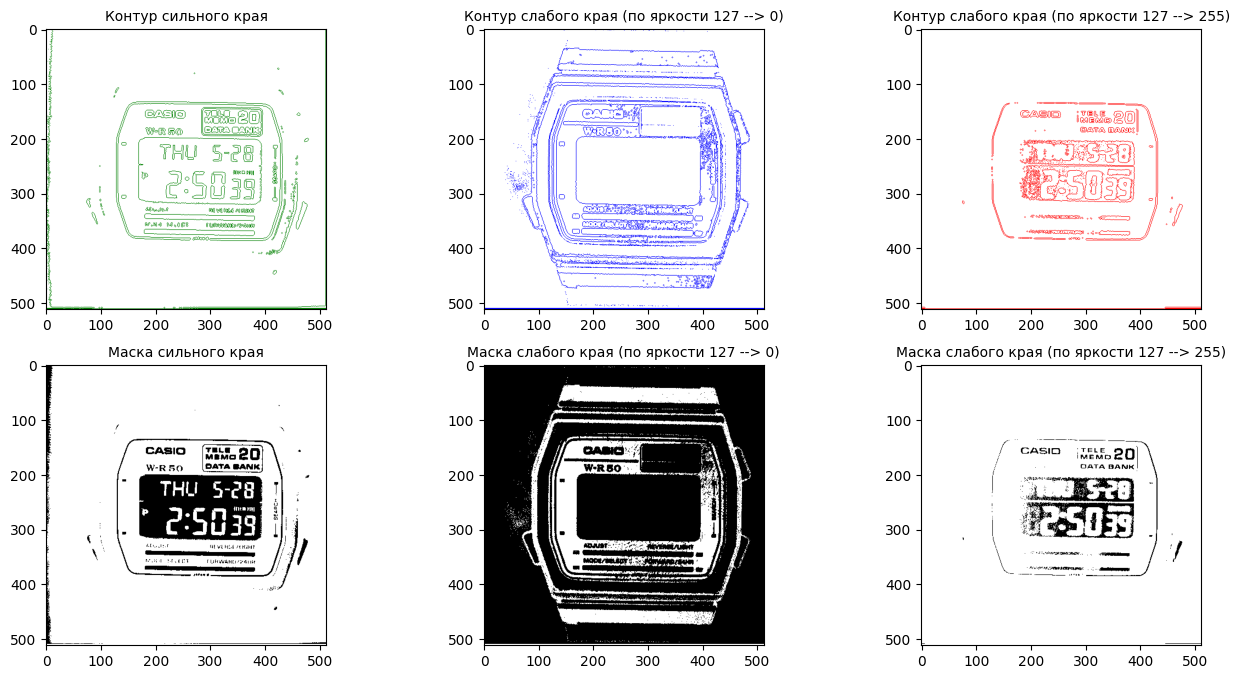

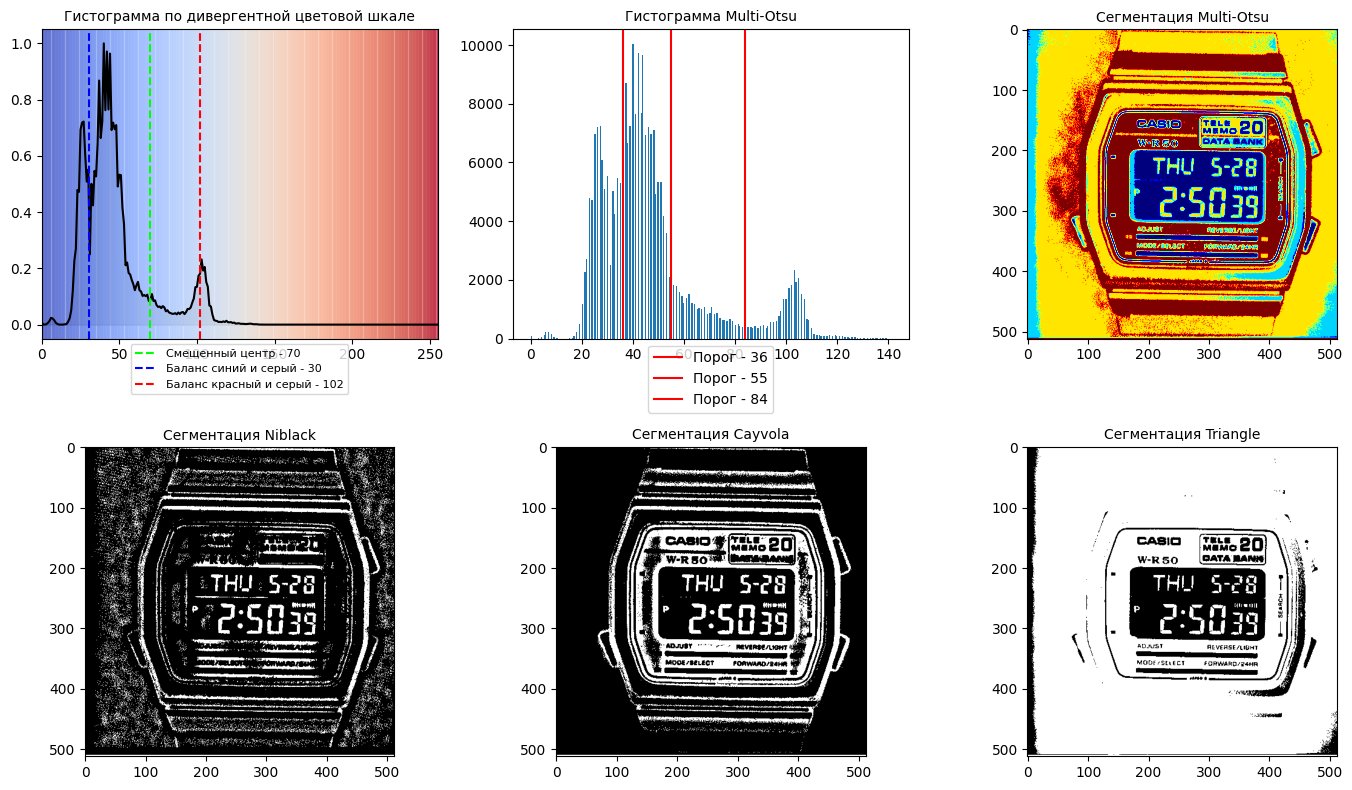

In [ ]:
file_path = "/content/drive/MyDrive/ZNAK/wat1.png"
gray_image = process_image(file_path)  # Вызываем первую функцию
contour_cw(gray_image)
alg_other(gray_image)